In [1]:
import os
import sys
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)


In [2]:
(x_train_full, y_train_full), (x_test, y_test) = keras.datasets.mnist.load_data()
x_valid, x_train = x_train_full[:5000] / 255, x_train_full[5000:] / 255
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
x_test = x_test / 255
(x_train.shape, x_valid.shape, x_test.shape)

((55000, 28, 28), (5000, 28, 28), (10000, 28, 28))

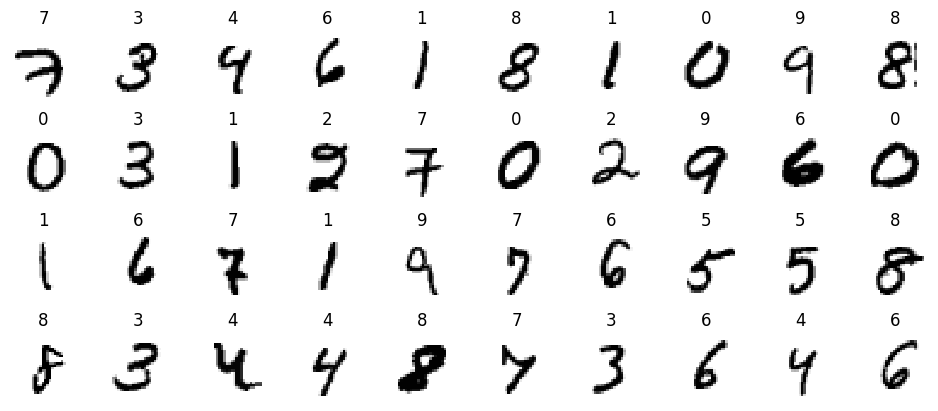

In [3]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(x_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(y_train[index], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

In [4]:
K = keras.backend


class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_batch_end(self, batch, logs):
        current_lr = K.get_value(self.model.optimizer.learning_rate)
        self.rates.append(current_lr)
        self.losses.append(logs["loss"])
        self.model.optimizer.learning_rate.assign(current_lr * self.factor)

In [5]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

expon_lr = ExponentialLearningRate(1.005)
model.fit(x_train, y_train, epochs=1, validation_data=(x_valid, y_valid), callbacks=[expon_lr])


1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6190 - loss: nan - val_accuracy: 0.0958 - val_loss: nan


Text(0, 0.5, 'loss')

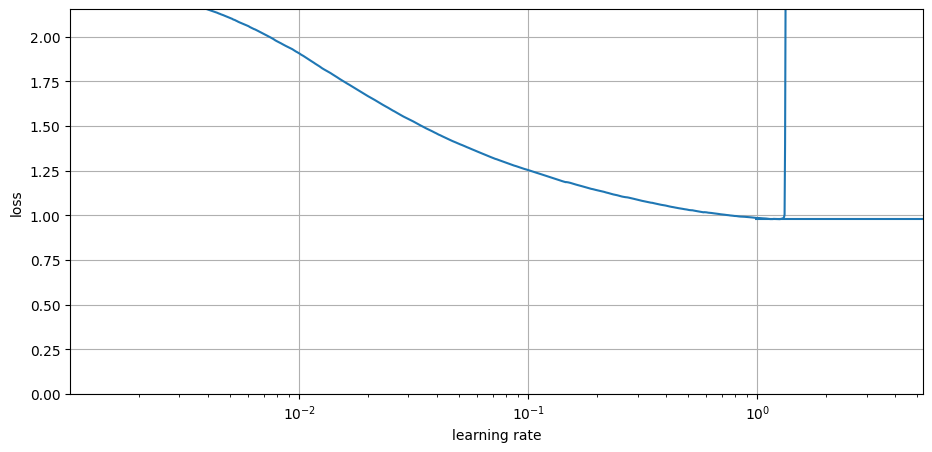

In [7]:
plt.figure(figsize=(11, 5))
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale("log")
plt.hlines(min(expon_lr.losses), min(expon_lr.losses), max(expon_lr.losses))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid(True)
plt.xlabel("learning rate")
plt.ylabel("loss")

In [8]:
min_loss = min(expon_lr.losses)
min_index = expon_lr.losses.index(min_loss)
best_learning_rate = float(expon_lr.rates[min_index] / 10)
print("Best learning rate:", best_learning_rate)

Best learning rate: 0.1239175796508789


In [9]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=best_learning_rate),
              metrics=["accuracy"])

In [10]:
from src.model_utils import Modelpath
from src.log_utils import logdir

model_path = Modelpath(model_name= "mnist_clf2", format = "keras")
Checkpoint_cb = keras.callbacks.ModelCheckpoint(model_path, save_best_only=True)
EarlyStopping_cb = keras.callbacks.EarlyStopping(patience=20)
tensorboard_cb = keras.callbacks.TensorBoard(log_dir=logdir("mnist_clf"))

In [11]:
model.fit(x_train, y_train, epochs=100, callbacks=[Checkpoint_cb, EarlyStopping_cb, tensorboard_cb],
          validation_data=(x_valid, y_valid))

Epoch 1/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9240 - loss: 0.2513 - val_accuracy: 0.9686 - val_loss: 0.1130
Epoch 2/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9705 - loss: 0.0995 - val_accuracy: 0.9754 - val_loss: 0.0804
Epoch 3/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9813 - loss: 0.0635 - val_accuracy: 0.9772 - val_loss: 0.0740
Epoch 4/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9875 - loss: 0.0430 - val_accuracy: 0.9796 - val_loss: 0.0735
Epoch 5/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9922 - loss: 0.0292 - val_accuracy: 0.9796 - val_loss: 0.0744
Epoch 6/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9950 - loss: 0.0195 - val_accuracy: 0.9808 - val_loss: 0.0741
Epoch 7/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9969 - loss: 0.0138 - val_accuracy: 0.9778 - val_loss: 0.0829
Epoch 8/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9979 - loss: 0

In [12]:
model = keras.models.load_model(model_path)
model.evaluate(x_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9783 - loss: 0.0757


[0.07570815086364746, 0.9782999753952026]